# 目录
+ 1 载入必要的包和数据
+ 2 特征工程后的模型
    + 2.1 随机森林
    + 2.2 GBM
    + 2.3 XGBoost
+ 3 特征选择
    + 3.1 自编函数前向选择
        + 9.1.1 随机森林
        + 9.1.2 GBM
        + 9.1.3 XGBoost
    + 3.2 RFECV后向选择
        + 9.2.1 随机森林
        + 9.2.2 GBM
        + 9.2.3 XGBoost    
    + 3.3 在基线模型基础上，逐一加入或剔除新构建的特征
        + 9.3.1 随机森林
        + 9.3.2 GBM
        + 9.3.3 XGBoost
+ 4 学习曲线
    + 11.1 随机森林
    + 11.2 GBM
    + 11.3 XGBoost
+ 5 调参
+ 6 过采样

# 1 载入必要的包和数据

In [9]:
import numpy as np
from pandas import Series, DataFrame
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
%matplotlib inline

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing

In [34]:
titanic = pd.read_csv('../data/train_preprocessed.csv')
titanic.columns

Index([u'PassengerId', u'Survived', u'Pclass', u'Name', u'Sex', u'Age',
       u'SibSp', u'Parch', u'Ticket', u'Fare', u'Cabin', u'Embarked',
       u'Pclass_1', u'Pclass_2', u'Pclass_3', u'Sex_encode', u'Cabin_notnull',
       u'Embarked_C', u'Embarked_Q', u'Embarked_S', u'Family_size',
       u'Name_len', u'Age_Child', u'Age_Adult', u'Age_Elder', u'Title',
       u'Child_1', u'Child_2', u'Child_3', u'Male_1', u'Male_2', u'Male_3',
       u'Female_1', u'Female_2', u'Female_3'],
      dtype='object')

In [66]:
test = pd.read_csv('../data/test_preprocessed.csv')
test.columns

Index([u'PassengerId', u'Pclass', u'Name', u'Sex', u'Age', u'SibSp', u'Parch',
       u'Ticket', u'Fare', u'Cabin', u'Embarked', u'Pclass_1', u'Pclass_2',
       u'Pclass_3', u'Sex_encode', u'Cabin_notnull', u'Embarked_C',
       u'Embarked_Q', u'Embarked_S', u'Family_size', u'Name_len', u'Age_Child',
       u'Age_Adult', u'Age_Elder', u'Title', u'Child_1', u'Child_2',
       u'Child_3', u'Male_1', u'Male_2', u'Male_3', u'Female_1', u'Female_2',
       u'Female_3'],
      dtype='object')

In [35]:
all_predictors = [x for x in titanic.columns if x not in ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']]
all_predictors

['Age',
 'SibSp',
 'Parch',
 'Fare',
 'Pclass_1',
 'Pclass_2',
 'Pclass_3',
 'Sex_encode',
 'Cabin_notnull',
 'Embarked_C',
 'Embarked_Q',
 'Embarked_S',
 'Family_size',
 'Name_len',
 'Age_Child',
 'Age_Adult',
 'Age_Elder',
 'Title',
 'Child_1',
 'Child_2',
 'Child_3',
 'Male_1',
 'Male_2',
 'Male_3',
 'Female_1',
 'Female_2',
 'Female_3']

# 2 建模

In [22]:
def modelfit(alg, dtrain, y, predictor, performCV=True, printFeatureImportance=True, cv_folds=5):
    # 训练模型
    alg.fit(dtrain[predictor], y)

    if performCV:
    # 交叉验证评分
        cv_score = model_selection.cross_val_score(alg, dtrain[predictor], y, cv=cv_folds, scoring='accuracy')
    
    # 输出交叉验证结果
        print "CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score))

    # 输出特征重要性评分
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictor).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

## 2.1 随机森林

CV Score : Mean - 0.8058795 | Std - 0.01520246 | Min - 0.7865169 | Max - 0.8305085


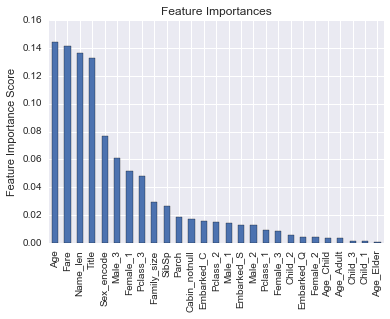

In [23]:
rf0 = RandomForestClassifier(random_state=1234)
modelfit(rf0, titanic, titanic['Survived'], all_predictors)

## 2.2 GBM

CV Score : Mean - 0.8215785 | Std - 0.0103846 | Min - 0.8089888 | Max - 0.8361582


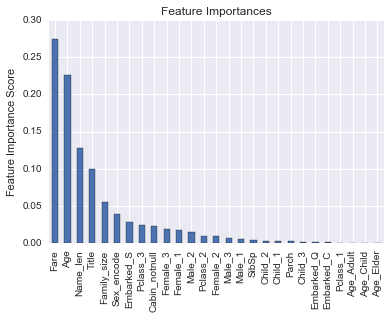

In [24]:
gbm0 = GradientBoostingClassifier(random_state=1234)
modelfit(gbm0, titanic, titanic['Survived'], all_predictors)

## 2.3 XGBoost

CV Score : Mean - 0.8204422 | Std - 0.006648915 | Min - 0.8146067 | Max - 0.8314607


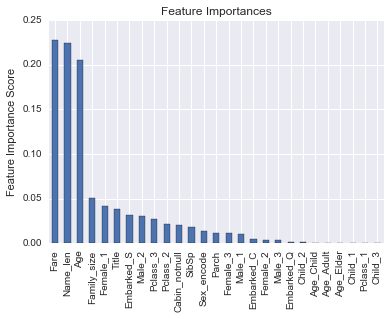

In [25]:
xgb0 = XGBClassifier(seed=1234)
modelfit(xgb0, titanic, titanic['Survived'], all_predictors)

### 可见，运用构造的全部特征建立的模型，效果反而比基线模型更差，因而需要进行特征选择

# 3 特征选择

## 3.1 自编函数前向选择

In [44]:
def feature_socre(alg, dtrain, y, features, cv_folds=5):
    alg.fit(dtrain[features], y)
    cv_score = model_selection.cross_val_score(alg, dtrain[features], y, cv=cv_folds, scoring='accuracy')
    return np.mean(cv_score)

In [45]:
def featureSelect(alg, dtrain, y, features):
    # alg是选择的算法
    # dtrain是训练集
    # y是标签
    # predictors是待选择的特征列表
    
    while len(features) != 0:
        
        feature_index = [] # 存放该轮依次被测试的特征
        score = [] # 存放该轮依次被测试特征的重要性评分

        for feature in features:
            # 用于存放测试过的特征，并按顺序将特征存放进feature_index列表   
            feature_index.append(feature)

            # 将待测特征与已经被选中的特征合并，从而执行前向选择
            feature_to_test = feature_set + [feature]

            # 交叉验证评分，并按顺序将评分存入score列表
            score.append(feature_socre(alg, titanic, titanic['Survived'], feature_to_test))

        feature_selected = Series(score, feature_index).sort_values(ascending=False).index[0]
        feature_selected_score = Series(score, feature_index).sort_values(ascending=False)[0]

        feature_set.append(feature_selected)
        feature_score.append([feature_selected, feature_selected_score])
        
        features.remove(feature_selected)

### 3.1.1 随机森林

In [46]:
rf_select_predictors = [
    'Age',
    'SibSp',
    'Parch',
    'Fare',
    'Pclass_1',
    'Pclass_2',
    'Pclass_3',
    'Sex_encode',
    'Cabin_notnull',
    'Embarked_C',
    'Embarked_Q',
    'Embarked_S',
    'Family_size',
    'Name_len',
    'Age_Child',
    'Age_Adult',
    'Age_Elder',
    'Title',
    'Child_1',
    'Child_2',
    'Child_3',
    'Male_1',
    'Male_2',
    'Male_3',
    'Female_1',
    'Female_2',
    'Female_3'
]

In [47]:
feature_set = [] # 存放所有被选上的特征，最终所有特征都会进入该列表
feature_score = [] # 存放所有被选上的特征及其重要性评分，最终所有特征都会进入该列表

rf0 = RandomForestClassifier(random_state=1234)
featureSelect(rf0, titanic, titanic['Survived'], rf_select_predictors)

In [48]:
DataFrame(feature_score)

,0,1
0,Title,0.786759
1,Family_size,0.815948
2,Female_1,0.826035
3,Age_Child,0.827172
4,Child_1,0.827172
5,Sex_encode,0.826048
6,Age_Elder,0.826048
7,Male_3,0.824931
8,Age_Adult,0.824918
9,Parch,0.821560


### 交叉验证最高得分为0.828276

+ 预测

In [90]:
rf0_fs_predictors = ['Title',
                     'Family_size',
                     'Female_1',
                     'Age_Child',
                     'Child_1',
                     'Sex_encode',
                     'Age_Elder',
                     'Male_3',
                     'Age_Adult',
                     'Parch',
                     'Embarked_Q'
                    ]

In [93]:
rf0_fs = RandomForestClassifier(random_state=1234)
rf0_fs.fit(titanic[rf0_fs_predictors], titanic['Survived'])
rf0_fs_prediction = rf0_fs.predict(test[rf0_fs_predictors])

In [94]:
rf0_fs_submmison = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': rf0_fs_prediction})
rf0_fs_submmison.to_csv('../result/rf0_fs_prediction.csv', index=None)

### 3.1.2 GBM

In [49]:
gbm_select_predictors = [
    'Age',
    'SibSp',
    'Parch',
    'Fare',
    'Pclass_1',
    'Pclass_2',
    'Pclass_3',
    'Sex_encode',
    'Cabin_notnull',
    'Embarked_C',
    'Embarked_Q',
    'Embarked_S',
    'Family_size',
    'Name_len',
    'Age_Child',
    'Age_Adult',
    'Age_Elder',
    'Title',
    'Child_1',
    'Child_2',
    'Child_3',
    'Male_1',
    'Male_2',
    'Male_3',
    'Female_1',
    'Female_2',
    'Female_3'
]

In [50]:
feature_set = [] # 存放所有被选上的特征，最终所有特征都会进入该列表
feature_score = [] # 存放所有被选上的特征及其重要性评分，最终所有特征都会进入该列表

gbm0 = GradientBoostingClassifier(random_state=1234)
featureSelect(gbm0, titanic, titanic['Survived'], gbm_select_predictors)

In [51]:
DataFrame(feature_score)

,0,1
0,Title,0.786759
1,SibSp,0.814818
2,Cabin_notnull,0.821566
3,Family_size,0.830561
4,Embarked_C,0.835030
5,Sex_encode,0.836160
6,Female_2,0.836167
7,Child_1,0.836167
8,Male_3,0.836179
9,Pclass_1,0.835049


### 交叉验证最高得分为0.836179

+ 预测

In [96]:
gbm0_fs_predictors = ['Title',
                     'SibSp',
                     'Cabin_notnull',
                     'Family_size',
                     'Embarked_C',
                     'Sex_encode',
                     'Female_2',
                     'Child_1',
                     'Male_3'
                    ]

In [97]:
gbm0_fs = GradientBoostingClassifier(random_state=1234)
gbm0_fs.fit(titanic[gbm0_fs_predictors], titanic['Survived'])
gbm0_fs_prediction = gbm0_fs.predict(test[gbm0_fs_predictors])

In [98]:
gbm0_fs_submmison = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': gbm0_fs_prediction})
gbm0_fs_submmison.to_csv('../result/gbm0_fs_prediction.csv', index=None)

### 3.1.3 XGBoost

In [52]:
xgb_select_predictors = [
    'Age',
    'SibSp',
    'Parch',
    'Fare',
    'Pclass_1',
    'Pclass_2',
    'Pclass_3',
    'Sex_encode',
    'Cabin_notnull',
    'Embarked_C',
    'Embarked_Q',
    'Embarked_S',
    'Family_size',
    'Name_len',
    'Age_Child',
    'Age_Adult',
    'Age_Elder',
    'Title',
    'Child_1',
    'Child_2',
    'Child_3',
    'Male_1',
    'Male_2',
    'Male_3',
    'Female_1',
    'Female_2',
    'Female_3'
]

In [53]:
feature_set = [] # 存放所有被选上的特征，最终所有特征都会进入该列表
feature_score = [] # 存放所有被选上的特征及其重要性评分，最终所有特征都会进入该列表

xgb0 = XGBClassifier(seed=1234)
featureSelect(xgb0, titanic, titanic['Survived'], xgb_select_predictors)

In [54]:
DataFrame(feature_score)

,0,1
0,Title,0.789006
1,Family_size,0.821560
2,Cabin_notnull,0.832783
3,Age_Elder,0.833907
4,Pclass_3,0.836160
5,Child_1,0.836160
6,Pclass_1,0.836160
7,Child_3,0.837278
8,Male_3,0.837278
9,Child_2,0.837278


### 交叉验证最高得分为0.837278

+ 预测

In [99]:
xgb0_fs_predictors = ['Title',
                     'Family_size',
                     'Cabin_notnull',
                     'Age_Elder',
                     'Pclass_3',
                     'Child_1',
                     'Pclass_1',
                     'Child_3'
                    ]

In [101]:
xgb0_fs = XGBClassifier(seed=1234)
xgb0_fs.fit(titanic[xgb0_fs_predictors], titanic['Survived'])
xgb0_fs_prediction = xgb0_fs.predict(test[xgb0_fs_predictors])

In [102]:
xgb0_fs_submmison = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': xgb0_fs_prediction})
xgb0_fs_submmison.to_csv('../result/xgb0_fs_prediction.csv', index=None)

## 3.2 RFECV后向选择

In [55]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

In [56]:
rf0 = RandomForestClassifier(random_state=1234)
gbm0 = GradientBoostingClassifier(random_state=1234)
xgb0 = XGBClassifier(seed=1234)

### 3.2.1 随机森林

In [58]:
rf0_rfecv = RFECV(estimator=rf0, step=1, cv=StratifiedKFold(5),
              scoring='accuracy')
rf0_rfecv.fit(titanic[all_predictors], titanic['Survived'])

RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
   estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=1234,
            verbose=0, warm_start=False),
   n_jobs=1, scoring='accuracy', step=1, verbose=0)

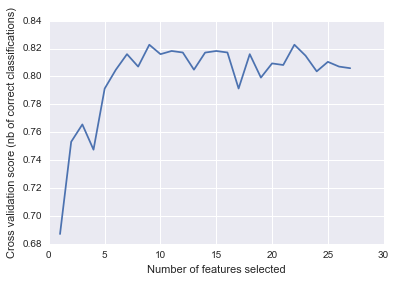

In [59]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rf0_rfecv.grid_scores_) + 1), rf0_rfecv.grid_scores_);

In [60]:
rf0_rfecv.grid_scores_.max()

0.82270838187423379

In [62]:
rf0_rfecv_predictors = list(Series(all_predictors)[rf0_rfecv.support_])
rf0_rfecv_predictors

['Age',
 'SibSp',
 'Parch',
 'Fare',
 'Pclass_1',
 'Pclass_2',
 'Pclass_3',
 'Sex_encode',
 'Cabin_notnull',
 'Embarked_C',
 'Embarked_Q',
 'Embarked_S',
 'Family_size',
 'Name_len',
 'Age_Child',
 'Age_Adult',
 'Title',
 'Male_1',
 'Male_2',
 'Male_3',
 'Female_1',
 'Female_2']

+ 预测

In [67]:
rf0_rfecv_estimator = RandomForestClassifier(random_state=1234)
rf0_rfecv_estimator.fit(titanic[rf0_rfecv_predictors], titanic['Survived'])
rf0_rfecv_prediction = rf0_rfecv_estimator.predict(test[rf0_rfecv_predictors])

In [68]:
rf0_rfecv_prediction = DataFrame(rf0_rfecv_prediction)
rf0_rfecv_prediction.columns = ['Survived']
rf0_rfecv_prediction = pd.concat([test[['PassengerId']], rf0_rfecv_prediction], axis=1)
rf0_rfecv_prediction.to_csv('../result/rf0_rfecv_addfeature_prediction.csv', index=None)

### 3.2.2 GBM

In [69]:
gbm0_rfecv = RFECV(estimator=gbm0, step=1, cv=StratifiedKFold(5),
              scoring='accuracy')
gbm0_rfecv.fit(titanic[all_predictors], titanic['Survived'])

RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
   estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=1234,
              subsample=1.0, verbose=0, warm_start=False),
   n_jobs=1, scoring='accuracy', step=1, verbose=0)

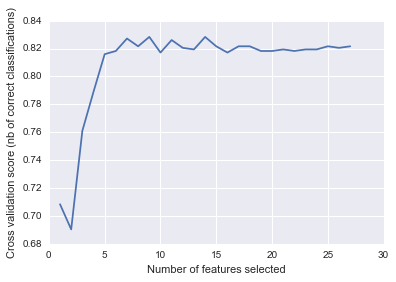

In [70]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(gbm0_rfecv.grid_scores_) + 1), gbm0_rfecv.grid_scores_);

In [71]:
gbm0_rfecv.grid_scores_.max()

0.82831401804462534

In [73]:
Series(all_predictors)[gbm0_rfecv.support_]

0             Age
3            Fare
6        Pclass_3
7      Sex_encode
11     Embarked_S
12    Family_size
13       Name_len
17          Title
22         Male_2
dtype: object

### 3.2.3 XGBoost

In [75]:
xgb0_rfecv = RFECV(estimator=xgb0, step=1, cv=StratifiedKFold(5),
              scoring='accuracy')
xgb0_rfecv.fit(titanic[all_predictors], titanic['Survived'])

RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
   estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=1234, silent=True, subsample=1),
   n_jobs=1, scoring='accuracy', step=1, verbose=0)

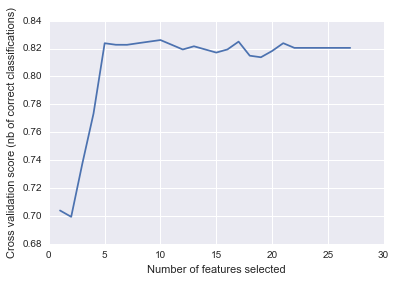

In [76]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(xgb0_rfecv.grid_scores_) + 1), xgb0_rfecv.grid_scores_);

In [77]:
xgb0_rfecv.grid_scores_.max()

0.82606040810883952

In [79]:
Series(all_predictors)[xgb0_rfecv.support_]

0               Age
3              Fare
5          Pclass_2
8     Cabin_notnull
11       Embarked_S
12      Family_size
13         Name_len
17            Title
22           Male_2
24         Female_1
dtype: object

### ``RFECV``进行后向选择的效果比自编函数前向选择的效果差，但运算速度明显更快。提交结果仍不理想，可能落入局部最优，试试逐一加入或剔除新构建的特征

## 3.3 在基线模型基础上，逐一加入或剔除新构建的特征

In [80]:
raw_predictors = [
    'Age',
    'SibSp',
    'Parch',
    'Fare',
    'Pclass_1',
    'Pclass_2',
    'Pclass_3',
    'Sex_encode',
    'Cabin_notnull',
    'Embarked_C',
    'Embarked_Q',
    'Embarked_S'
]

### 3.3.1 随机森林

+ 随机森林基线模型

CV Score : Mean - 0.8013974 | Std - 0.03113943 | Min - 0.7696629 | Max - 0.8539326


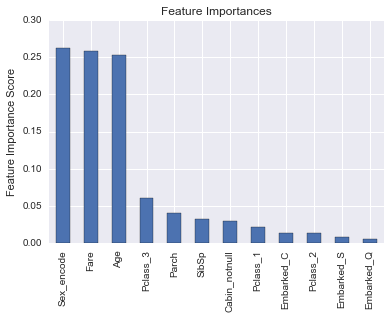

In [81]:
rf0 = RandomForestClassifier(random_state=1234)
modelfit(rf0, titanic, titanic['Survived'], raw_predictors)

+ 手工选择特征

In [103]:
rf_predictors = ['Title', 'Family_size', 'Cabin_notnull', 'Age_Child', 'Parch', 'Embarked_Q', 'Age_Elder']

CV Score : Mean - 0.8260604 | Std - 0.0102759 | Min - 0.8146067 | Max - 0.8418079


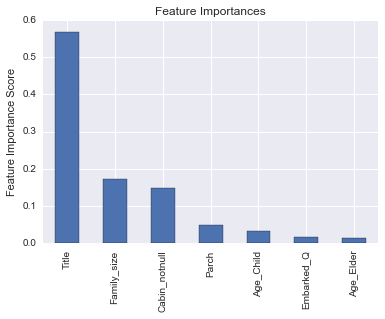

In [84]:
rf0 = RandomForestClassifier(random_state=1234)
modelfit(rf0, titanic, titanic['Survived'], rf_predictors)

In [132]:
rf_addsex_predictors = ['Title', 'Family_size', 'Cabin_notnull', 'Age_Child', 'Parch', 'Embarked_Q', 'Age_Elder', 'Sex_encode']

CV Score : Mean - 0.8238258 | Std - 0.01577406 | Min - 0.8033708 | Max - 0.8474576


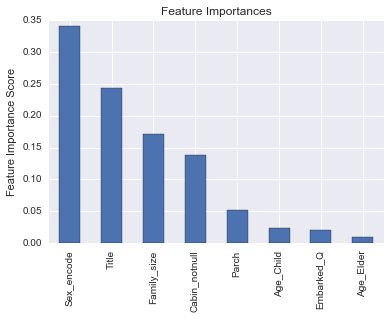

In [133]:
rf0 = RandomForestClassifier(random_state=1234)
modelfit(rf0, titanic, titanic['Survived'], rf_addsex_predictors)

### 最终确定，随机森林模型使用的特征如下：

In [17]:
rf_predictors = ['Title', 'Family_size', 'Cabin_notnull', 'Age_Child', 'Parch', 'Embarked_Q', 'Age_Elder']
rf_addsex_predictors = ['Title', 'Family_size', 'Cabin_notnull', 'Age_Child', 'Parch', 'Embarked_Q', 'Age_Elder', 'Sex_encode']

+ 预测

In [129]:
rf0 = RandomForestClassifier(random_state=1234)
rf0.fit(titanic[rf_predictors], titanic['Survived'])
rf0_prediction = rf0.predict(test[rf_predictors])

In [130]:
rf0_prediction = DataFrame(rf0_prediction)
rf0_prediction.columns = ['Survived']
rf0_prediction = pd.concat([test[['PassengerId']], rf0_prediction], axis=1)
rf0_prediction.to_csv('../result/rf0_prediction.csv', index=None)

In [129]:
rf0 = RandomForestClassifier(random_state=1234)
rf0.fit(titanic[test_predictors], titanic['Survived'])
rf0_addsex_prediction = rf0.predict(test[test_predictors])

In [130]:
rf0_addsex_prediction = DataFrame(rf0_addsex_prediction)
rf0_addsex_prediction.columns = ['Survived']
rf0_addsex_prediction = pd.concat([test[['PassengerId']], rf0_addsex_prediction], axis=1)
rf0_addsex_prediction.to_csv('../result/rf0_addsex_prediction.csv', index=None)

### 3.3.2 GBM

+ GBM基线模型

CV Score : Mean - 0.8260983 | Std - 0.01960792 | Min - 0.8033708 | Max - 0.8587571


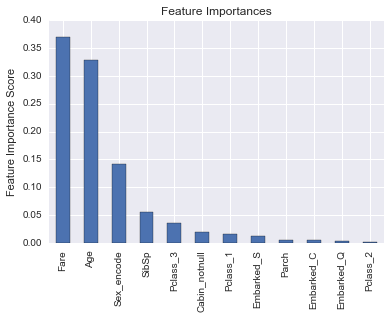

In [85]:
gbm0 = GradientBoostingClassifier(random_state=1234)
modelfit(gbm0, titanic, titanic['Survived'], raw_predictors)

+ 手工选择特征

In [135]:
gbm_predictors = ['Age', 'SibSp', 'Parch', 'Fare', 'Pclass_1', 'Pclass_3', 'Sex_encode', 'Cabin_notnull', 'Embarked_C', 'Embarked_S']

CV Score : Mean - 0.8328399 | Std - 0.01999473 | Min - 0.8146067 | Max - 0.8644068


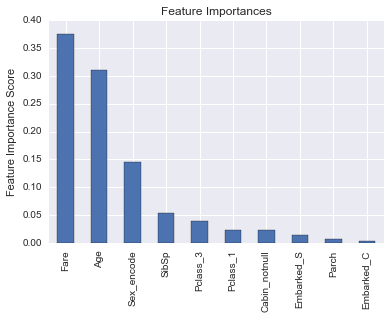

In [344]:
gbm0 = GradientBoostingClassifier(random_state=1234)
modelfit(gbm0, titanic, titanic['Survived'], gbm_predictors)

### 最终确定，GBM模型使用的特征如下：

In [285]:
gbm_predictors = ['Age', 'SibSp', 'Parch', 'Fare', 'Pclass_1', 'Pclass_3', 'Sex_encode', 'Cabin_notnull', 'Embarked_C', 'Embarked_S']

+ 预测

In [52]:
gbm0 = GradientBoostingClassifier(random_state=1234)
gbm0.fit(titanic[gbm_predictors], titanic['Survived'])
gbm0_prediction = gbm0.predict(test[gbm_predictors])

In [105]:
gbm0_prediction = DataFrame(gbm0_prediction)
gbm0_prediction.columns = ['Survived']
gbm0_prediction = pd.concat([test[['PassengerId']], gbm0_prediction], axis=1)
gbm0_prediction.to_csv('../result/gbm0_prediction.csv', index=None)

### 3.3.3 XGBoost

+ XGBoost基线模型

CV Score : Mean - 0.8272281 | Std - 0.02397257 | Min - 0.8033708 | Max - 0.8595506


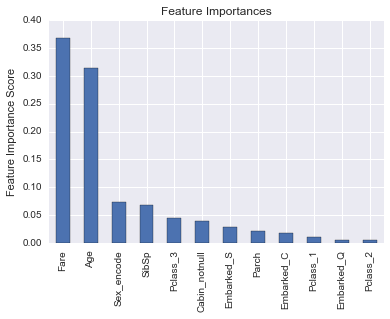

In [59]:
xgb0 = XGBClassifier(seed=1234)
modelfit(xgb0, titanic, titanic['Survived'], raw_predictors)

+ 手工选择特征

In [134]:
xgb_predictors = ['Age', 'SibSp', 'Parch', 'Fare', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_encode', 'Cabin_notnull', 'Embarked_C',
                  'Embarked_Q', 'Embarked_S', 'Title', 'Family_size']

CV Score : Mean - 0.8350366 | Std - 0.01281924 | Min - 0.8202247 | Max - 0.8539326


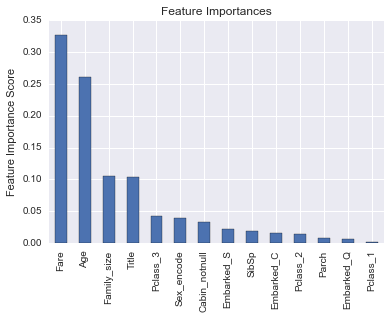

In [114]:
xgb0 = XGBClassifier(seed=1234)
modelfit(xgb0, titanic, titanic['Survived'], xgb_predictors)

### 最终确定，XGBoost模型使用的特征如下：

In [284]:
xgb_predictors = ['Age', 'SibSp', 'Parch', 'Fare', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_encode', 'Cabin_notnull', 'Embarked_C',
                  'Embarked_Q', 'Embarked_S', 'Title', 'Family_size']

+ 预测

In [53]:
xgb0 = XGBClassifier(seed=1234)
xgb0.fit(titanic[xgb_predictors], titanic['Survived'])
xgb0_prediction = xgb0.predict(test[xgb_predictors])

In [107]:
xgb0_prediction = DataFrame(xgb0_prediction)
xgb0_prediction.columns = ['Survived']
xgb0_prediction = pd.concat([test[['PassengerId']], xgb0_prediction], axis=1)
xgb0_prediction.to_csv('../result/xgb0_prediction.csv', index=None)

### 上传结果，rf0击败了Benchmark，gbm0和xgb0结果比Benchmark差，预测结果与交叉验证结果相反，可能过拟合。  
### 下面绘制学习曲线来看看到底有没有过拟合。

# 4 学习曲线

In [56]:
# learning_curve计算training_score、cv_score，自编函数绘制learning curve
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.05, 1.0, 20)):
    """
    参数：
    ----------
    estimator : 分类器
    title : 图表的标题
    X : 特征
    y : 标签
    ylim : (ymin, ymax)，图表y轴上的界限
    cv : 默认3折
         当y为类别变量，自动应用StratifiedKFold，否则应用KFold
    n_jobs : 并行线程数
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    # 用learning_curve计算模型在训练集、验证集上的得分，并用均值平滑曲线，用方差绘制置信区间
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    # 绘制置信区间
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    # 绘制学习曲线
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")    
    plt.grid(True)
    
    return plt

## 4.1 随机森林

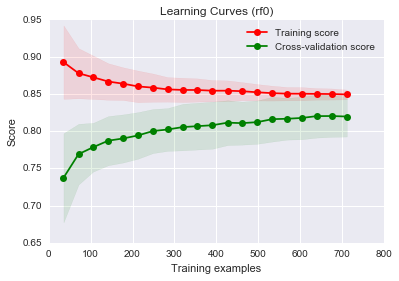

In [57]:
title = "Learning Curves (rf0)"
# 设置n_splits=100，使学习曲线更加光滑
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
plot_learning_curve(rf0, title, titanic[rf_predictors], titanic['Survived'], cv=cv);

## 4.2 GBM

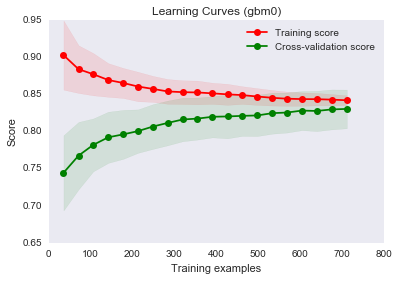

In [54]:
title = "Learning Curves (gbm0)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
plot_learning_curve(gbm0, title, titanic[rf_predictors], titanic['Survived'], cv=cv);

## 4.3 XGBoost

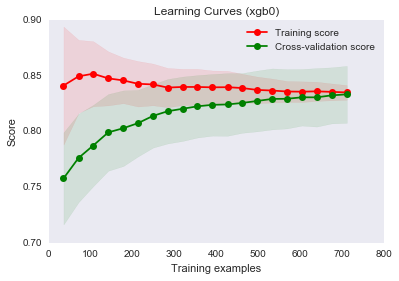

In [55]:
title = "Learning Curves (xgb0)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
plot_learning_curve(xgb0, title, titanic[rf_predictors], titanic['Survived'], cv=cv);

### 结果令人困惑，rf0的学习曲线gap较大，显示有过拟合的可能，而gbm0和xgb0的gap很小，显示没有过拟合。

# 5 调参

In [305]:
rf_predictors = ['Title', 'Family_size', 'Cabin_notnull', 'Age_Child', 'Parch', 'Embarked_Q', 'Age_Elder']

+ n_estimators=50

In [311]:
param_test1 = {'n_estimators':range(10,151,10)}
gsearch1 = GridSearchCV(
    estimator = RandomForestClassifier(min_samples_split=4, max_depth=5, max_features='sqrt', random_state=1234),
    param_grid = param_test1, scoring='accuracy',n_jobs=-1,iid=False, cv=5)
gsearch1.fit(titanic[rf_predictors],titanic['Survived'])

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=4, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=1234,
            verbose=0, warm_start=False),
       fit_params={}, iid=False, n_jobs=-1,
       param_grid={'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [312]:
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

C:\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:662: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.82384, std: 0.01250, params: {'n_estimators': 10},
  mean: 0.82942, std: 0.01127, params: {'n_estimators': 20},
  mean: 0.82942, std: 0.01127, params: {'n_estimators': 30},
  mean: 0.82942, std: 0.01127, params: {'n_estimators': 40},
  mean: 0.83055, std: 0.01315, params: {'n_estimators': 50},
  mean: 0.83055, std: 0.01315, params: {'n_estimators': 60},
  mean: 0.83055, std: 0.01315, params: {'n_estimators': 70},
  mean: 0.82942, std: 0.01127, params: {'n_estimators': 80},
  mean: 0.82942, std: 0.01127, params: {'n_estimators': 90},
  mean: 0.82942, std: 0.01127, params: {'n_estimators': 100},
  mean: 0.82942, std: 0.01127, params: {'n_estimators': 110},
  mean: 0.82942, std: 0.01127, params: {'n_estimators': 120},
  mean: 0.82942, std: 0.01127, params: {'n_estimators': 130},
  mean: 0.82942, std: 0.01127, params: {'n_estimators': 140},
  mean: 0.82942, std: 0.01127, params: {'n_estimators': 150}],
 {'n_estimators': 50},
 0.83055493198599761)

+ max_depth=11, min_samples_split=8

In [319]:
param_test2 = {'max_depth':range(1,16,1), 'min_samples_split':range(2,10,2)}
gsearch2 = GridSearchCV(
    estimator = RandomForestClassifier(n_estimators=50, max_features='sqrt', random_state=1234),
    param_grid = param_test2, scoring='accuracy',n_jobs=-1,iid=False, cv=5)
gsearch2.fit(titanic[rf_predictors],titanic['Survived'])

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=1234,
            verbose=0, warm_start=False),
       fit_params={}, iid=False, n_jobs=-1,
       param_grid={'min_samples_split': [2, 4, 6, 8], 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [320]:
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

C:\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:662: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.72846, std: 0.02374, params: {'min_samples_split': 2, 'max_depth': 1},
  mean: 0.72846, std: 0.02374, params: {'min_samples_split': 4, 'max_depth': 1},
  mean: 0.72846, std: 0.02374, params: {'min_samples_split': 6, 'max_depth': 1},
  mean: 0.72846, std: 0.02374, params: {'min_samples_split': 8, 'max_depth': 1},
  mean: 0.78123, std: 0.02106, params: {'min_samples_split': 2, 'max_depth': 2},
  mean: 0.78123, std: 0.02106, params: {'min_samples_split': 4, 'max_depth': 2},
  mean: 0.78123, std: 0.02106, params: {'min_samples_split': 6, 'max_depth': 2},
  mean: 0.78123, std: 0.02106, params: {'min_samples_split': 8, 'max_depth': 2},
  mean: 0.79583, std: 0.02678, params: {'min_samples_split': 2, 'max_depth': 3},
  mean: 0.79583, std: 0.02678, params: {'min_samples_split': 4, 'max_depth': 3},
  mean: 0.79583, std: 0.02678, params: {'min_samples_split': 6, 'max_depth': 3},
  mean: 0.80030, std: 0.02692, params: {'min_samples_split': 8, 'max_depth': 3},
  mean: 0.82271, std: 0.0103

+ max_depth=11, min_samples_split=8

In [319]:
param_test2 = {'max_depth':range(1,16,1), 'min_samples_split':range(2,10,2)}
gsearch2 = GridSearchCV(
    estimator = RandomForestClassifier(n_estimators=50, max_features='sqrt', random_state=1234),
    param_grid = param_test2, scoring='accuracy',n_jobs=-1,iid=False, cv=5)
gsearch2.fit(titanic[rf_predictors],titanic['Survived'])

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=1234,
            verbose=0, warm_start=False),
       fit_params={}, iid=False, n_jobs=-1,
       param_grid={'min_samples_split': [2, 4, 6, 8], 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [320]:
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

C:\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:662: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.72846, std: 0.02374, params: {'min_samples_split': 2, 'max_depth': 1},
  mean: 0.72846, std: 0.02374, params: {'min_samples_split': 4, 'max_depth': 1},
  mean: 0.72846, std: 0.02374, params: {'min_samples_split': 6, 'max_depth': 1},
  mean: 0.72846, std: 0.02374, params: {'min_samples_split': 8, 'max_depth': 1},
  mean: 0.78123, std: 0.02106, params: {'min_samples_split': 2, 'max_depth': 2},
  mean: 0.78123, std: 0.02106, params: {'min_samples_split': 4, 'max_depth': 2},
  mean: 0.78123, std: 0.02106, params: {'min_samples_split': 6, 'max_depth': 2},
  mean: 0.78123, std: 0.02106, params: {'min_samples_split': 8, 'max_depth': 2},
  mean: 0.79583, std: 0.02678, params: {'min_samples_split': 2, 'max_depth': 3},
  mean: 0.79583, std: 0.02678, params: {'min_samples_split': 4, 'max_depth': 3},
  mean: 0.79583, std: 0.02678, params: {'min_samples_split': 6, 'max_depth': 3},
  mean: 0.80030, std: 0.02692, params: {'min_samples_split': 8, 'max_depth': 3},
  mean: 0.82271, std: 0.0103

+ min_samples_leaf=1, min_samples_split=8

In [323]:
param_test3 = {'min_samples_split':range(8,11,1), 'min_samples_leaf':range(1,21,1)}
gsearch3 = GridSearchCV(
    estimator = RandomForestClassifier(n_estimators=50, max_depth=11, max_features='sqrt', random_state=1234),
    param_grid = param_test3, scoring='accuracy',n_jobs=-1,iid=False, cv=5)
gsearch3.fit(titanic[rf_predictors],titanic['Survived'])

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=11, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=1234,
            verbose=0, warm_start=False),
       fit_params={}, iid=False, n_jobs=-1,
       param_grid={'min_samples_split': [8, 9, 10], 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [324]:
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

C:\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:662: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.83167, std: 0.00977, params: {'min_samples_split': 8, 'min_samples_leaf': 1},
  mean: 0.82942, std: 0.01293, params: {'min_samples_split': 9, 'min_samples_leaf': 1},
  mean: 0.83166, std: 0.01216, params: {'min_samples_split': 10, 'min_samples_leaf': 1},
  mean: 0.83055, std: 0.00930, params: {'min_samples_split': 8, 'min_samples_leaf': 2},
  mean: 0.83167, std: 0.00977, params: {'min_samples_split': 9, 'min_samples_leaf': 2},
  mean: 0.82942, std: 0.01182, params: {'min_samples_split': 10, 'min_samples_leaf': 2},
  mean: 0.83055, std: 0.01103, params: {'min_samples_split': 8, 'min_samples_leaf': 3},
  mean: 0.82718, std: 0.01317, params: {'min_samples_split': 9, 'min_samples_leaf': 3},
  mean: 0.82718, std: 0.01317, params: {'min_samples_split': 10, 'min_samples_leaf': 3},
  mean: 0.82831, std: 0.01109, params: {'min_samples_split': 8, 'min_samples_leaf': 4},
  mean: 0.82718, std: 0.01317, params: {'min_samples_split': 9, 'min_samples_leaf': 4},
  mean: 0.82831, std: 0.01226

+ max_features=4

In [325]:
param_test4 = {'max_features':range(1,8,1)}
gsearch4 = GridSearchCV(
    estimator = RandomForestClassifier(n_estimators=50, max_depth=11, min_samples_leaf=1, min_samples_split=8, max_features='sqrt', random_state=1234),
    param_grid = param_test4, scoring='accuracy',n_jobs=-1,iid=False, cv=5)
gsearch4.fit(titanic[rf_predictors],titanic['Survived'])

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=11, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=8, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=1234,
            verbose=0, warm_start=False),
       fit_params={}, iid=False, n_jobs=-1,
       param_grid={'max_features': [1, 2, 3, 4, 5, 6, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [326]:
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

C:\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:662: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.82942, std: 0.01293, params: {'max_features': 1},
  mean: 0.83167, std: 0.00977, params: {'max_features': 2},
  mean: 0.82942, std: 0.01071, params: {'max_features': 3},
  mean: 0.83167, std: 0.01302, params: {'max_features': 4},
  mean: 0.82944, std: 0.01270, params: {'max_features': 5},
  mean: 0.83055, std: 0.01267, params: {'max_features': 6},
  mean: 0.82944, std: 0.01270, params: {'max_features': 7}],
 {'max_features': 4},
 0.83167225042175175)

n_estimators=50, max_depth=11/4, min_samples_split=8/5, min_samples_leaf=1, max_features=4

In [336]:
rf_tuning = RandomForestClassifier(n_estimators=50, max_depth=11, min_samples_split=8, min_samples_leaf=1, max_features=4, random_state=1234)

In [337]:
rf_tuning.fit(titanic[rf_predictors], titanic['Survived'])
rf_tuning_prediction = rf_tuning.predict(test[rf_predictors])

In [338]:
rf_tuning_submmison = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': rf_tuning_prediction})
rf_tuning_submmison.to_csv('../result/rf_tuning_prediction.csv', index=None)

# 6 过采样

In [50]:
rf_tuning_classweight = RandomForestClassifier(n_estimators=50, max_depth=11, min_samples_split=8, min_samples_leaf=1, max_features=4,
                                   class_weight={0: .5, 1: .5}, random_state=1234)

CV Score : Mean - 0.8316723 | Std - 0.01302432 | Min - 0.8146067 | Max - 0.8531073


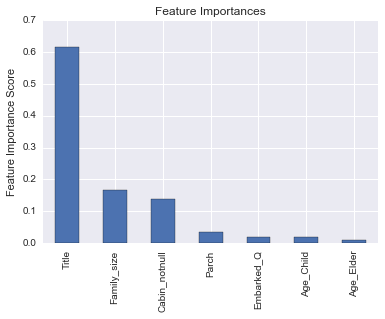

In [51]:
modelfit(rf_tuning_classweight, titanic, titanic['Survived'], rf_predictors)

In [46]:
rf_tuning_classweight.fit(titanic[rf_predictors], titanic['Survived'])
rf_tuning_classweight_prediction = rf_tuning_classweight.predict(test[rf_predictors])

In [47]:
rf_tuning_classweight_submmison = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': rf_tuning_classweight_prediction})
rf_tuning_classweight_submmison.to_csv('../result/rf_tuning_classweight_prediction.csv', index=None)